# Problem Description

- This data set was created to list all shows available on Netflix streaming, and analyze the data to find interesting facts. This data was acquired in July 2022 containing data available in the United States

## Tasks

- Developing a content-based recommender system using the genres and/or descriptions
- Identifying the main content available on the streaming.
- Network analysis on the cast of the titles

- Exploratory data analysis to find interesting insightsts.

## Datasets
This dataset has two files containing the titles (titles.csv) and the cast (credits.csv) for the title.

## Titles Dataset
This dataset contains +5k unique titles on Netflix with 15 columns containing their information, including:

- **id:** The title ID on JustWatch.
- **title:** The name of the title.
- **show_type:** TV show or movie.
- **description:** A brief description.
- **release_year:** The release year.
- **age_certification:** The age certification.
- **runtime:** The length of the episode (SHOW) or movie.
- **genres:** A list of genres.
- **production_countries:** A list of countries that produced the title.
- **seasons:** Number of seasons if it's a SHOW.
- **imdb_id:** The title ID on IMDB.
- **imdb_score:** Score on IMDB.
- **imdb_votes:** Votes on IMDB.
- **tmdb_popularity:** Popularity on TMDB.
- **tmdb_score:** Score on TMDB.

## Credits Dataset
And over +77k credits of actors and directors on Netflix titles with 5 columns containing their information, including:

- **person_ID:** The person ID on JustWatch.
- **id:** The title ID on JustWatch.
- **name:** The actor or director's name.
- **character_name:** The character name.
- **role:** ACTOR or DIRECTOR.

# Import Libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import ast

import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [88]:
df_credits = pd.read_csv('Data/credits.csv')
df_titles =  pd.read_csv('Data/titles.csv')                       

In [138]:
df = pd.merge(df_credits, df_titles, on='id')
df.head()

,person_id,id,name,character,role,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,7064,tm84618,Albert Brooks,Tom,ACTOR,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179


# Data Cleaning

In [139]:
df = df.drop(["id","person_id", "imdb_id"], axis=1)

- dropping columns that will not be needed for the model

In [140]:
df.head()

,name,character,role,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,Robert De Niro,Travis Bickle,ACTOR,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179
1,Jodie Foster,Iris Steensma,ACTOR,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179
2,Albert Brooks,Tom,ACTOR,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179
3,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179
4,Cybill Shepherd,Betsy,ACTOR,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179


In [141]:
df.shape

(77801, 16)

In [142]:
df.isna().sum()

name                        0
character                9772
role                        0
title                       1
type                        0
description                38
release_year                0
age_certification       31143
runtime                     0
genres                      0
production_countries        0
seasons                 63091
imdb_score               3950
imdb_votes               4037
tmdb_popularity            11
tmdb_score               1137
dtype: int64

In [143]:
df.dtypes

name                     object
character                object
role                     object
title                    object
type                     object
description              object
release_year              int64
age_certification        object
runtime                   int64
genres                   object
production_countries     object
seasons                 float64
imdb_score              float64
imdb_votes              float64
tmdb_popularity         float64
tmdb_score              float64
dtype: object

In [144]:
df.duplicated().sum()

5

In [145]:
df = df.drop_duplicates()

In [146]:
# remove quotation marks and brackets
def clean_columns(s):
    return ', '.join(ast.literal_eval(s))

df['genres'] = df['genres'].apply(clean_columns)
df['production_countries'] = df['production_countries'].apply(clean_columns)

# Feature Engineering

# Exploratory Data Analysis

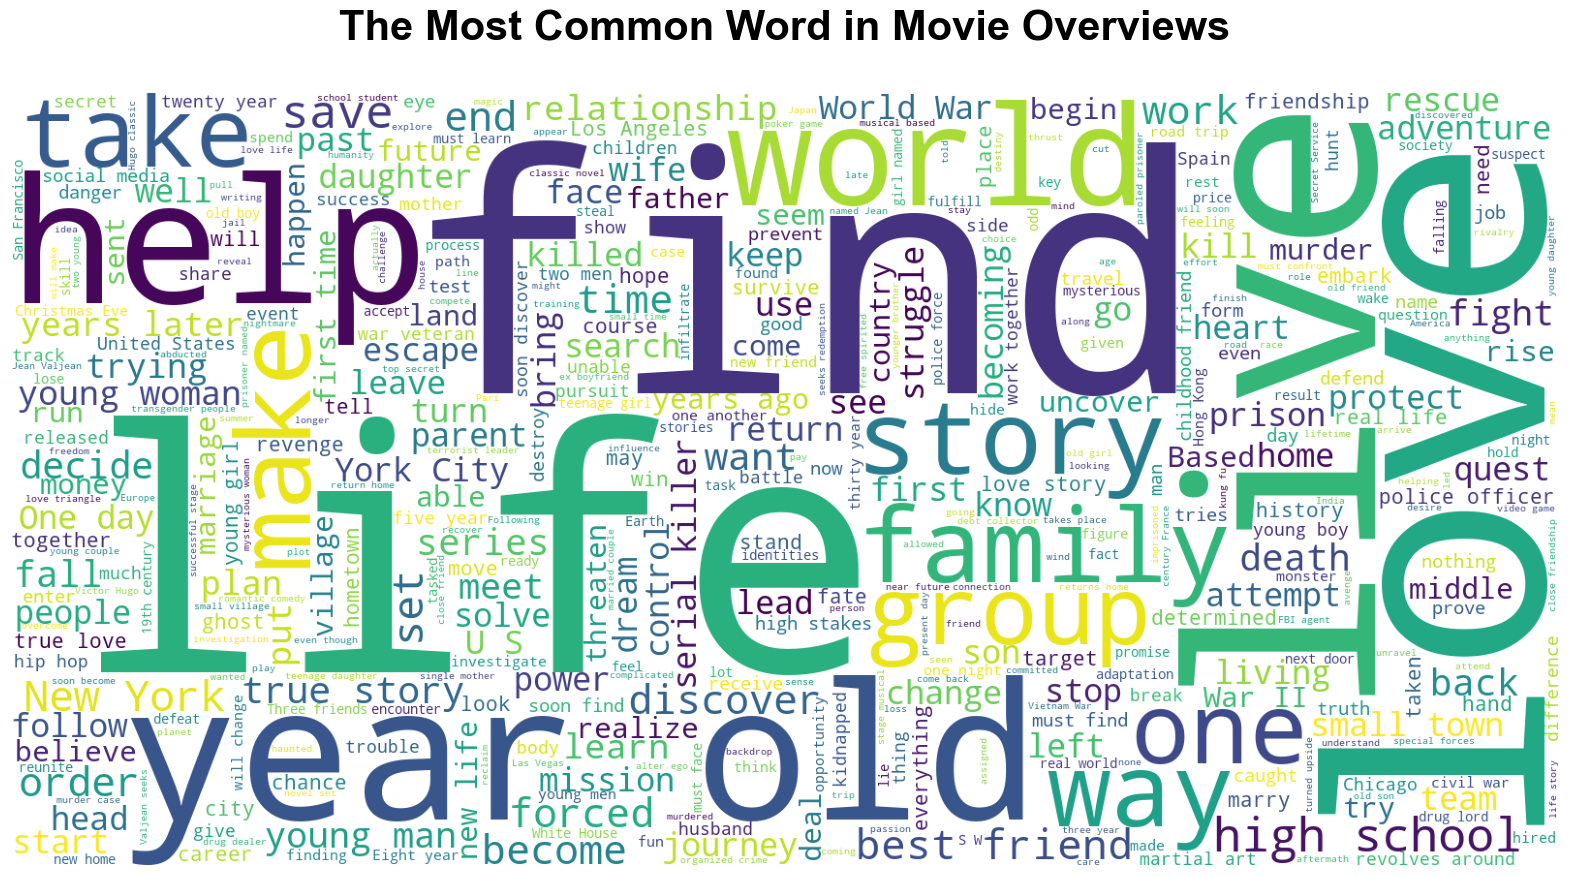

In [44]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='black')
text_data = ' '.join(df['description'].astype(str))

wc = WordCloud(max_words=1000, min_font_size=10,
               height=800, width=1600, background_color="white").generate(text_data)

plt.imshow(wc)
plt.axis("off")
plt.show()

- We can see that the words that stand out most in the feature **description** are 'love', 'life', 'find' and 'live'

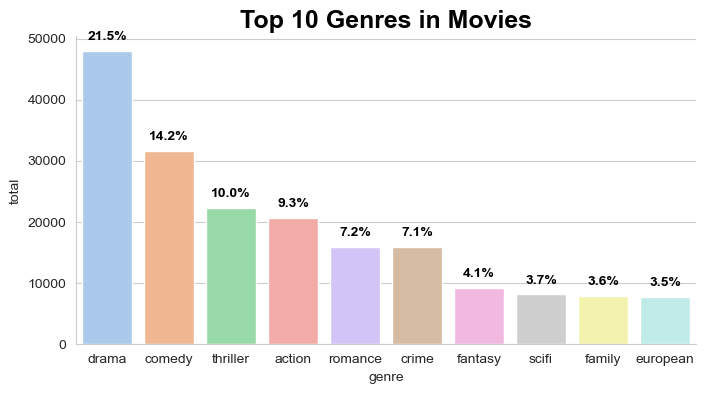

In [117]:
sns.set_style("whitegrid")
genres_list = []
for i in df['genres']:
    genres_list.extend(genre.strip(' ') for genre in i.split(', '))

plt.figure(figsize=(8,4))
df_plot = pd.DataFrame(Counter(genres_list).most_common(10), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', palette=sns.color_palette('pastel', n_colors=10))
plt.title('Top 10 Genres in Movies', fontsize=18, weight=600, color='black')
sns.despine()

for p in ax.patches:
    ax.annotate(f'{p.get_height() / len(genres_list) * 100:.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10, color='black', weight='bold')

plt.show()

- Drama is the most dominant genre with over 48000 movies
- Out of 10 top genres, there are still many genres in the dataset. They hold 62,2% of total genres in the movies

In [99]:
ax1 = df_titles.groupby('age_certification').size().reset_index(name='sum')

In [100]:
ax1

,age_certification,sum
0,G,124
1,NC-17,16
2,PG,233
3,PG-13,451
4,R,556
5,TV-14,474
6,TV-G,79
7,TV-MA,883
8,TV-PG,188
9,TV-Y,107


- G (General Audience) -- non adult
- NC-17 (No One 17 and Under Admitted) -- adult
- PG (Parental Guidance Suggested) -- non adult
- PG-13 (Parents Strongly Cautioned) -- non adult
- R (Restricted) -- non adult
- TV-14 (Parents Strongly Cautioned - TV) -- non adult
- TV-G (General Audience - TV) -- non adult
- TV-MA (Mature Audience Only - TV) -- adult
- TV-PG (Parental Guidance Suggested - TV) -- non adult
- TV-Y (All Children - TV) -- non adult
- TV-Y7 (Directed to Older Children - TV) -- non adult

In [101]:
ax2 = df_titles['age_certification'].apply(lambda x: 'adult' if x in ['NC-17', 'TV-MA'] else 'non adult').reset_index(name='age_certification', drop=True)
ax2 = pd.DataFrame(ax2)

In [102]:
ax2

,age_certification
0,adult
1,non adult
2,non adult
3,non adult
4,non adult
...,...
5845,non adult
5846,non adult
5847,non adult
5848,non adult


In [103]:
ax3 = ax2.groupby('age_certification').size().reset_index(name='sum')
ax3

,age_certification,sum
0,adult,899
1,non adult,4951


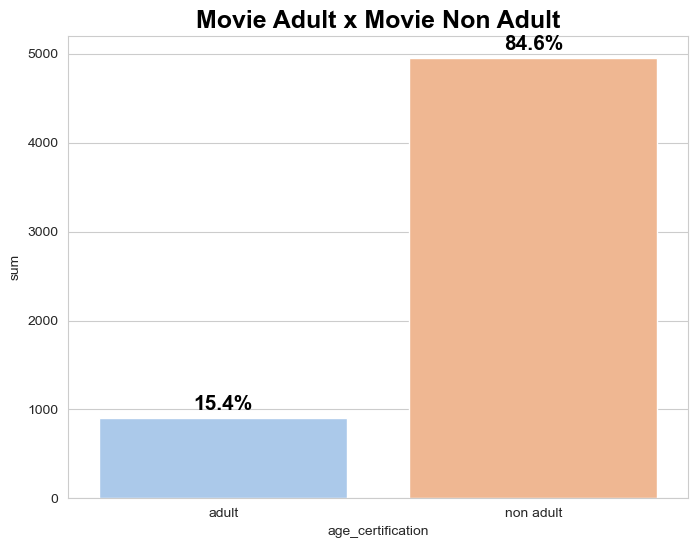

In [128]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x='age_certification', y='sum', data=ax3, palette='pastel')
plt.title('Movie Adult x Movie Non Adult', fontsize=18, weight=600, color='black')

for p in ax.patches:
    ax.annotate(f'{p.get_height() / len(df_titles) * 100:.1f}%',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=15, color='black', weight='bold')


plt.show()

- There is a huge difference between these two types of films in terms of the age rating for this dataset

In [150]:
ax = df_titles.groupby('release_year').size().reset_index(name='sum')
ax

,release_year,sum
0,1945,1
1,1954,2
2,1956,1
3,1958,1
4,1959,1
...,...,...
58,2018,773
59,2019,836
60,2020,814
61,2021,787


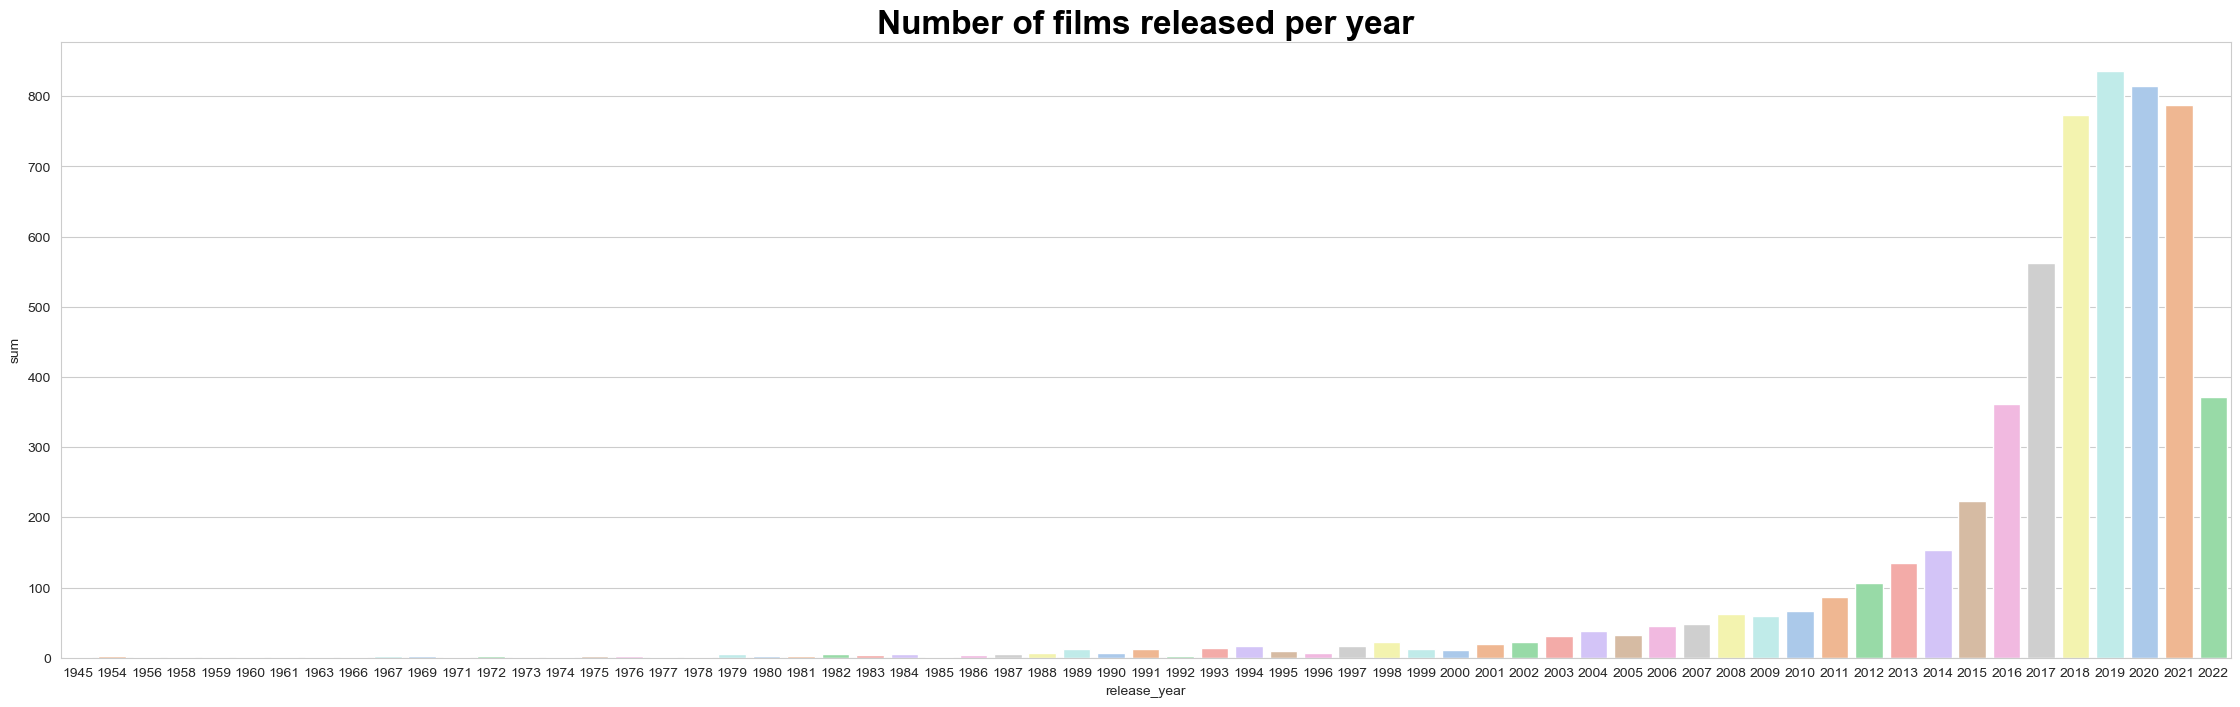

In [158]:
plt.figure(figsize=(28, 8))
sns.barplot(x='release_year', y='sum', data=ax, palette='pastel')
plt.title('Number of films released per year', fontsize=24, weight=600, color='black')

plt.show()

- We can see that the number of films released per year has increased almost exponentially, however in recent years there has been a drop, 
  I think due to the COVID context and that this dataset did not include the entire year 2022

# Model